In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import data
from hyperparameters import SimArgs
from parameters import weight_generation, weight_generation_1h
from jax.example_libraries import optimizers
# check gpu with jax
print(jax.devices())

[CpuDevice(id=0)]


In [3]:
import jax; print(jax.numpy.arange(10))

[0 1 2 3 4 5 6 7 8 9]


In [2]:
!pip3 freeze

anyio==4.3.0
appnope==0.1.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
attrs==23.2.0
Babel==2.14.0
beautifulsoup4==4.12.3
bleach==6.1.0
certifi==2024.2.2
cffi==1.16.0
charset-normalizer==3.3.2
comm==0.2.2
contourpy==1.2.1
cycler==0.12.1
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
exceptiongroup==1.2.1
executing==2.0.1
fastjsonschema==2.19.1
filelock==3.13.4
fonttools==4.51.0
fqdn==1.5.1
fsspec==2024.3.1
h11==0.14.0
h5py==3.9.0
httpcore==1.0.5
httpx==0.27.0
idna==3.7
ipykernel==6.29.4
ipython==8.24.0
isoduration==20.11.0
jax==0.4.20
jax-metal==0.0.5
jaxlib==0.4.20
jedi==0.19.1
Jinja2==3.1.3
joblib==1.4.0
json5==0.9.25
jsonpointer==2.4
jsonschema==4.21.1
jsonschema-specifications==2023.12.1
jupyter-events==0.10.0
jupyter-lsp==2.2.5
jupyter_client==8.6.1
jupyter_core==5.7.2
jupyter_server==2.14.0
jupyter_server_terminals==0.5.3
jupyterlab==4.1.8
jupyterlab_pygments==0.3.0
jupyterlab_server==2.27.1
kiwisolver==1.4.5
MarkupSafe==2.1

In [2]:
# pip3 install notebook==7.0.4 pandas==2.1.1 torch==2.2.0 h5py==3.9.0 matplotlib==3.8.0 scikit-learn==1.3.1 jax==0.4.16 jaxlib==0.4.16

In [3]:
n_in = 700
n_h = 256 
seed = 42
tau_mem = 20e-3
transition_steps = 1000
transition_begin = 1000
noise_injection_std = 0.1
nb_epochs = 150
args = SimArgs(n_in, n_h, seed, tau_mem, transition_steps, transition_begin, noise_injection_std, nb_epochs)
args.lr = 0.001

In [4]:
train_loader, val_loader, test_loader = data.get_data_loaders(args)
in_spikes_test_batch0, gt_labels_test_batch0 = next(iter(test_loader))
print(f'{in_spikes_test_batch0.shape=}, {gt_labels_test_batch0.shape=}')
print(f'We will vmap on the first dimension, so each thread will process one sample of size {in_spikes_test_batch0.shape[1:]}')
print(f'We will scan on the first dimension of the sample, so at every timestep we will process a 1-D array of size {in_spikes_test_batch0.shape[2]}')

datasets:
 - available at: /Users/tristantorchet/Desktop/SNN/audiospikes_700/shd_train.h5
 - available at: /Users/tristantorchet/Desktop/SNN/audiospikes_700/shd_test.h5
in_spikes_test_batch0.shape=(64, 150, 700), gt_labels_test_batch0.shape=(64,)
We will vmap on the first dimension, so each thread will process one sample of size (150, 700)
We will scan on the first dimension of the sample, so at every timestep we will process a 1-D array of size 700


In [5]:
@jax.custom_jvp
def gr_than(x, thr):
    """ Thresholding function for spiking neurons. """
    return (x > thr).astype(jnp.float32)


@gr_than.defjvp
def gr_jvp(primals, tangents):
    """ Surrogate gradient function for thresholding. """
    x, thr = primals
    x_dot, y_dot = tangents
    primal_out = gr_than(x, thr)
    tangent_out = x_dot / (10 * jnp.absolute(x - thr) + 1)**2
    return primal_out, tangent_out

def lif_forward(state, input_spikes):
    ''' Vectorized Leaky Integrate and Fire (LIF) neuron model
    '''
    w, (i, v, z) = state[0]
    tau_mem, v_th, timestep = state[1]
    i = jnp.dot(w, input_spikes)  # + jnp.dot(Wrec, S_h)
    v = (1 - timestep / tau_mem) * v + i - z * v_th
    v = jnp.maximum(0, v)
    z = gr_than(v, v_th)

    return ((w, (i, v, z)), state[1]), (i, v, z)

def lif_recurrent(state, input_spikes):
    ''' Vectorized Recurrent Leaky Integrate and Fire (LIF) neuron model
    '''
    ((Win, Wrec, Wout), (i_h, v_h, z_h), (i, v, z)) = state[0]

    tau_mem, v_th, timestep = state[1]
    i_h = jnp.dot(Win, input_spikes) + jnp.dot(Wrec, z_h)
    v_h = (1 - timestep / tau_mem) * v_h + i_h - z_h * v_th
    v_h = jnp.maximum(0, v_h)
    z_h = gr_than(v_h, v_th)
    i = jnp.dot(Wout, z_h)
    v = (1 - timestep / tau_mem) * v + i - z * v_th
    v = jnp.maximum(0, v)
    z = gr_than(v, v_th)
    return (([Win, Wrec, Wout], (i_h, v_h, z_h), (i, v, z)), state[1]), (z_h, v, z)
    
    

In [14]:

def prediction(w, hp, in_spikes):
    i = jnp.zeros((w.shape[0],))
    v = jnp.zeros((w.shape[0],))
    z = jnp.zeros((w.shape[0],))
    state = ((w, (i, v, z)), hp) 
    _, (i, v, z) = jax.lax.scan(lif_forward, state, in_spikes)
    return i, v, z

def prediction_1hr(w, hp, in_spikes):
    i_h = jnp.zeros((w[0].shape[0],))
    v_h = jnp.zeros((w[0].shape[0],))
    z_h = jnp.zeros((w[0].shape[0],))
    i = jnp.zeros((w[2].shape[0],))
    v = jnp.zeros((w[2].shape[0],))
    z = jnp.zeros((w[2].shape[0],))
    state = ((w, (i_h, v_h, z_h), (i, v, z)), hp)
    _, (z_h, v, z) = jax.lax.scan(lif_recurrent, state, in_spikes)
    return z_h, v, z

    
prediction_jv = jax.jit(jax.vmap(prediction, in_axes=(None, None, 0)), static_argnums=(1,))

prediction_jv_1hr = jax.jit(jax.vmap(prediction_1hr, in_axes=(None, None, 0)), static_argnums=(1,))

def loss_fn(w, hp, in_spikes, gt_labels):
    _, v, _ = prediction_jv(w, hp, in_spikes)
    out = jnp.max(v, axis=1)
    logit = jax.nn.softmax(out)
    loss = -jnp.mean(jnp.log(logit[jnp.arange(gt_labels.shape[0]), gt_labels]))
    
    pred = jnp.argmax(out, axis=1)
    acc = jnp.count_nonzero(pred == gt_labels) / gt_labels.shape[0]
    return loss, acc

def loss_fn_1hr(w, hp, in_spikes, gt_labels):
    _, v, _ = prediction_jv_1hr(w, hp, in_spikes)
    out = jnp.max(v, axis=1)
    logit = jax.nn.softmax(out)
    loss = -jnp.mean(jnp.log(logit[jnp.arange(gt_labels.shape[0]), gt_labels]))
    
    pred = jnp.argmax(out, axis=1)
    acc = jnp.count_nonzero(pred == gt_labels) / gt_labels.shape[0]
    return loss, acc

def update(w, hp, in_spikes, gt_labels):
    (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(w, hp, in_spikes, gt_labels)
    w = w - args.lr * grads
    return w, (loss, acc)

def update_1hr(w, hp, in_spikes, gt_labels):
    (loss, acc), grads = jax.value_and_grad(loss_fn_1hr, has_aux=True)(w, hp, in_spikes, gt_labels)
    return (loss, acc), grads
    

def run_epoch(w, hp, loader):
    epoch_loss = jnp.zeros((len(loader)))
    epoch_acc = jnp.zeros((len(loader)))
    for id_batch, (in_spikes, gt_labels) in enumerate(loader):
        w, (loss, acc) = update(w, hp, in_spikes, gt_labels)
        epoch_loss = epoch_loss.at[id_batch].set(loss)
        epoch_acc = epoch_acc.at[id_batch].set(acc)
    return w, epoch_loss, epoch_acc

def run_epoch_1hr(get_params, opt_state, opt_update, hp, loader, e):
    epoch_loss = jnp.zeros((len(loader)))
    epoch_acc = jnp.zeros((len(loader)))
    for id_batch, (in_spikes, gt_labels) in enumerate(loader):
        w = get_params(opt_state)
        (loss, acc), grads = update_1hr(w, hp, in_spikes, gt_labels)
        opt_state = opt_update(e, grads, opt_state)
        epoch_loss = epoch_loss.at[id_batch].set(loss)
        epoch_acc = epoch_acc.at[id_batch].set(acc)
    return (epoch_loss, epoch_acc), opt_state


def train(w, hp, train_loader, val_loader, test_loader):
    
    opt_init, opt_update, get_params = optimizers.adam(step_size=args.lr)
    opt_state = opt_init(w)
    print(f'{"Epoch":<6}|{"Loss":<10}|{"Acc":<10}|{"Val Acc":<10}|{"Test Acc":<10}|{"Val Loss":<10}|{"Test Loss":<10}')
    print(f'{"-"*6}|{"-"*10}|{"-"*10}|{"-"*10}|{"-"*10}|{"-"*10}|{"-"*10}')
    best_val_acc = 0.05 # Random guess
    patience = 20
    for e in range(args.nb_epochs):
        (epoch_loss, epoch_acc), opt_state = run_epoch_1hr(get_params, opt_state, opt_update, hp, train_loader, e)
        (val_loss, val_acc), _ = run_epoch_1hr(get_params, opt_state, opt_update, hp, val_loader, e)
        if val_acc.mean() > best_val_acc:
            best_val_acc = val_acc.mean()
            patience = 20
            (test_loss, test_acc), _ = run_epoch_1hr(get_params, opt_state, opt_update, hp, test_loader, e)
            print(f'{e:<6}|{epoch_loss.mean():<10.4f}|{epoch_acc.mean():<10.4f}|{val_acc.mean():<10.4f}|{test_acc.mean():<10.4f}|{val_loss.mean():<10.4f}|{test_loss.mean():<10.4f}')
        else:
            patience -= 1
            if e % 10 == 0:
                print(f'{e:<6}|{epoch_loss.mean():<10.4f}|{epoch_acc.mean():<10.4f}|{val_acc.mean():<10.4f}|{"-":<10}|{val_loss.mean():<10.4f}|{"-":<10}')  
                
    return get_params, opt_state

In [81]:
w = train(w, hp, train_loader, val_loader, test_loader)

Epoch |Loss      |Acc       |Val Acc   |Test Acc  |Val Loss  |Test Loss 
------|----------|----------|----------|----------|----------|----------
0     |2.9435    |0.0808    |0.1112    |0.1312    |2.8809    |2.8359    
1     |2.8458    |0.1324    |0.1319    |0.1554    |2.8043    |2.7598    
2     |2.7722    |0.1641    |0.1875    |0.1844    |2.7376    |2.6917    
3     |2.7072    |0.1931    |0.1931    |0.2013    |2.6762    |2.6345    
4     |2.6501    |0.2008    |0.2013    |0.2214    |2.6212    |2.5829    
5     |2.6001    |0.2234    |0.2287    |0.2424    |2.5714    |2.5367    
7     |2.5174    |0.2390    |0.2437    |0.2643    |2.5009    |2.4613    
9     |2.4506    |0.2616    |0.2469    |0.2759    |2.4388    |2.3992    
10    |2.4218    |0.2738    |0.2469    |-         |2.4159    |-         
11    |2.3952    |0.2814    |0.2594    |0.2978    |2.3929    |2.3535    
12    |2.3713    |0.2894    |0.2725    |0.3000    |2.3686    |2.3317    
15    |2.3082    |0.3079    |0.2731    |0.3165    |

In [82]:
# compute the rank of the weight matrix
from scipy.linalg import svdvals
print(f'{np.linalg.matrix_rank(w)=}')

np.linalg.matrix_rank(w)=20


In [51]:
i, v, z = prediction_jv(w_original, hp, in_spikes_test_batch0)

NameError: name 'w_original' is not defined

In [105]:
print(f'{z.shape=}')

z.shape=(64, 150, 20)


In [106]:
z0 = z[0]
# compute the PCA of the output spikes
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

z0_pca = pca.fit_transform(z0)

In [107]:
print(f'{z0_pca.shape=}')

z0_pca.shape=(150, 2)


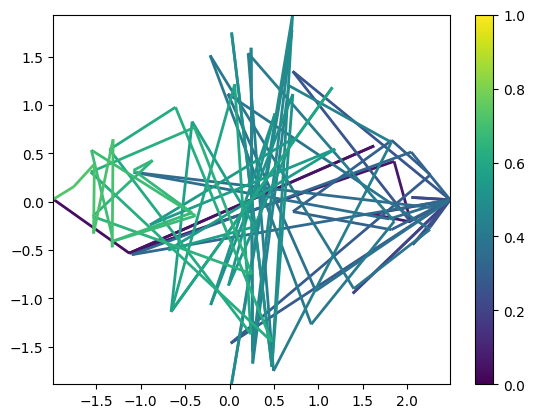

In [108]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

t = np.arange(z0.shape[0])
#plt.scatter(z0_pca[:, 0], z0_pca[:, 1], c=t, cmap='viridis')
x    = z0_pca[:, 0]
y    = z0_pca[:, 1]
cols = np.linspace(0,1,len(x))

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots()
lc = LineCollection(segments, cmap='viridis')
lc.set_array(cols)
lc.set_linewidth(2)
line = ax.add_collection(lc)
# set x and y limits
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
fig.colorbar(line,ax=ax)

# make the line a gradient of color
# display colorbar
#plt.colorbar()
plt.show()

In [15]:
from parameters import weight_generation

key = jax.random.PRNGKey(args.seed)
key, w = weight_generation_1h(key, args, visualize_plot=False)
win_original = w[0]
wrec_original = w[1]
wout_original = w[2]
print(f'{win_original.shape=}, {wrec_original.shape=}, {wout_original.shape=}')
hp = (args.tau_mem, args.v_thr, args.timestep)


win_original.shape=(256, 700), wrec_original.shape=(256, 256), wout_original.shape=(20, 256)


In [16]:
w = train(w, hp, train_loader, val_loader, test_loader)

Epoch |Loss      |Acc       |Val Acc   |Test Acc  |Val Loss  |Test Loss 
------|----------|----------|----------|----------|----------|----------
0     |2.6428    |0.1603    |0.2494    |0.2969    |2.2360    |2.0871    
1     |2.1142    |0.2980    |0.3363    |0.3804    |1.9930    |1.8705    
2     |1.9179    |0.3643    |0.3719    |0.4192    |1.8537    |1.7496    
3     |1.7788    |0.4137    |0.3944    |0.4545    |1.7625    |1.6566    
4     |1.6754    |0.4451    |0.4156    |0.4884    |1.6796    |1.5821    
5     |1.5921    |0.4776    |0.4569    |0.5009    |1.6056    |1.5197    
6     |1.5213    |0.5012    |0.4675    |0.5098    |1.5443    |1.4697    
7     |1.4533    |0.5238    |0.4975    |0.5375    |1.4807    |1.4066    
8     |1.3939    |0.5487    |0.5150    |0.5491    |1.4397    |1.3605    
9     |1.3405    |0.5729    |0.5281    |0.5576    |1.3968    |1.3316    
10    |1.2740    |0.5917    |0.5500    |0.5799    |1.3164    |1.2678    
11    |1.2103    |0.6077    |0.5681    |0.5991    |

In [18]:
for i, wi in enumerate(w): 
    jnp.save(f'w_{i}.npy', wi)

In [19]:
zh, v, z = prediction_jv_1hr(w, hp, in_spikes_test_batch0)


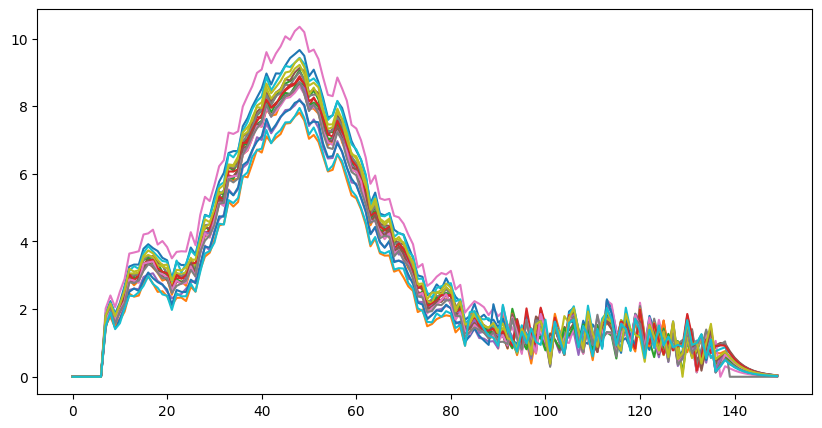

In [26]:
import matplotlib.pyplot as plt
v0 = v[6]
# plot the membrane potential of the 20 neurons with 150 timestep 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(20):
    ax.plot(v0[:, i], label=f'Neuron {i}')

In [48]:
id_sample = 14
print(gt_labels_test_batch0[id_sample])
zh0 = zh[id_sample]
# compute the PCA of the hidden spikes
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

zh0_pca = pca.fit_transform(zh0)

0


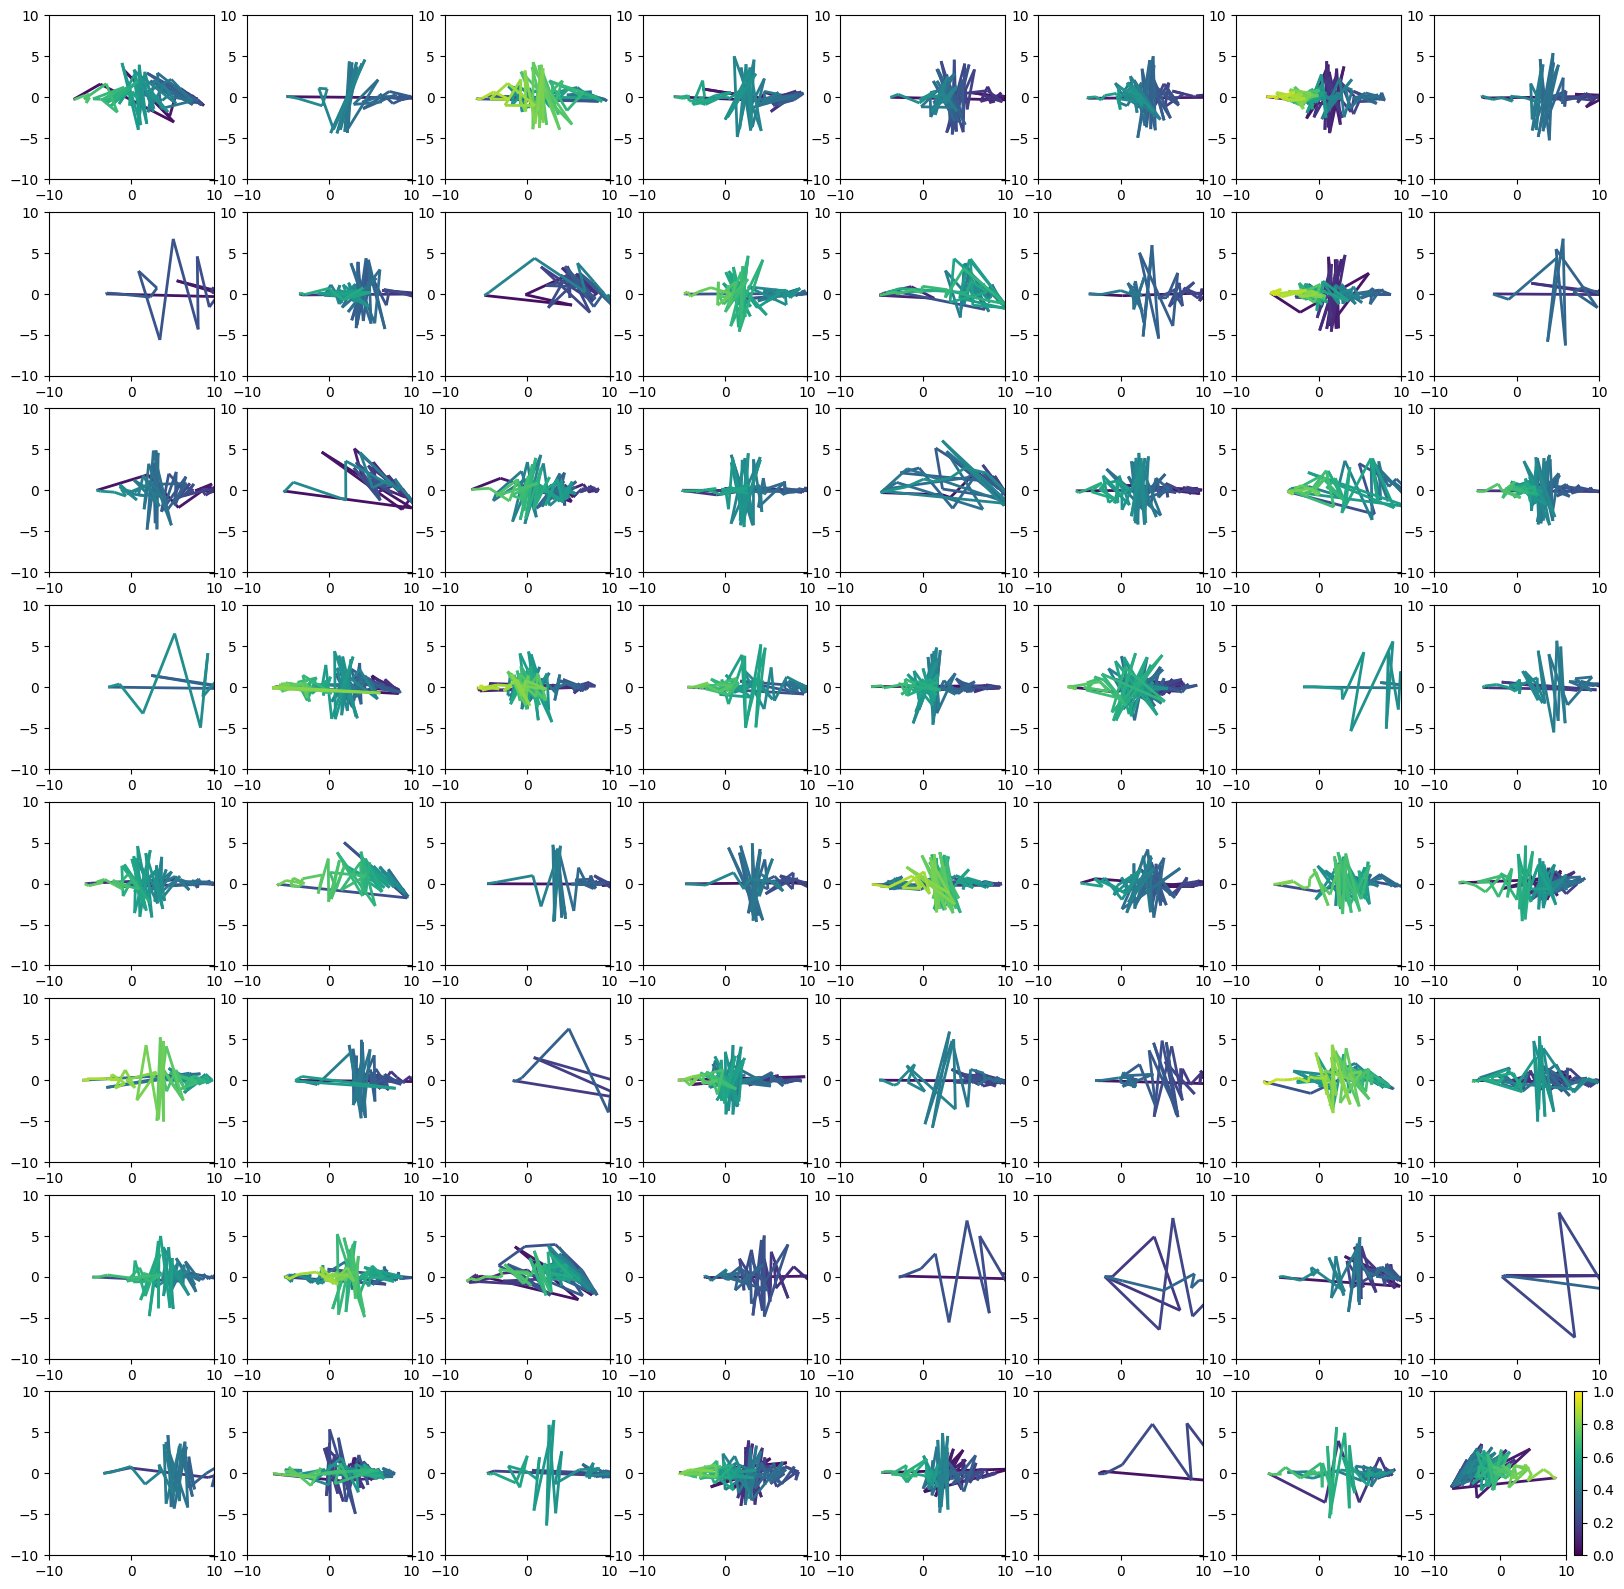

In [55]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

t = np.arange(zh0.shape[0])
#plt.scatter(z0_pca[:, 0], z0_pca[:, 1], c=t, cmap='viridis')
x    = zh0_pca[:, 0]
y    = zh0_pca[:, 1]
cols = np.linspace(0,1,len(x))


fig, axs = plt.subplots(8, 8, figsize=(20, 20))
for i in range(64):
    zh0 = zh[i]
    zh0_pca = pca.fit_transform(zh0)
    x    = zh0_pca[:, 0]
    y    = zh0_pca[:, 1]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cols = np.linspace(0,1,len(x))
    lc = LineCollection(segments, cmap='viridis')
    lc.set_array(cols)
    lc.set_linewidth(2)
    line = axs[i//8, i%8].add_collection(lc)
    # set x and y limits
    axs[i//8, i%8].set_xlim(-10, 10)
    axs[i//8, i%8].set_ylim(-10, 10)
fig.colorbar(line,ax=axs[i//8, i%8])

# make the line a gradient of color
# display colorbar
#plt.colorbar()
plt.show()

In [24]:
wrec = w[1]
# compute the rank of wrec
from scipy.linalg import svdvals
print(f'{np.linalg.matrix_rank(wrec)=}')


np.linalg.matrix_rank(wrec)=256


In [25]:
print(f'{np.linalg.matrix_rank(wrec_original)}')

256


(array([7.002e+03, 6.987e+03, 6.916e+03, 6.985e+03, 6.835e+03, 6.890e+03,
        6.665e+03, 6.570e+03, 6.445e+03, 6.087e+03, 6.282e+03, 6.075e+03,
        5.893e+03, 5.659e+03, 5.394e+03, 5.480e+03, 5.025e+03, 4.762e+03,
        4.706e+03, 4.443e+03, 4.059e+03, 4.054e+03, 3.773e+03, 3.672e+03,
        3.433e+03, 3.325e+03, 2.937e+03, 2.810e+03, 2.703e+03, 2.501e+03,
        2.232e+03, 2.074e+03, 1.966e+03, 1.859e+03, 1.660e+03, 1.471e+03,
        1.399e+03, 1.290e+03, 1.197e+03, 1.050e+03, 9.910e+02, 8.560e+02,
        8.130e+02, 6.740e+02, 6.370e+02, 6.040e+02, 4.980e+02, 4.320e+02,
        3.810e+02, 3.550e+02, 3.040e+02, 2.550e+02, 2.410e+02, 2.280e+02,
        1.880e+02, 1.660e+02, 1.330e+02, 1.290e+02, 1.040e+02, 8.900e+01,
        7.200e+01, 6.400e+01, 5.200e+01, 5.200e+01, 6.300e+01, 3.100e+01,
        4.800e+01, 2.100e+01, 2.800e+01, 2.300e+01, 1.700e+01, 1.600e+01,
        1.300e+01, 6.000e+00, 1.100e+01, 7.000e+00, 5.000e+00, 1.000e+00,
        4.000e+00, 5.000e+00, 5.000e+0

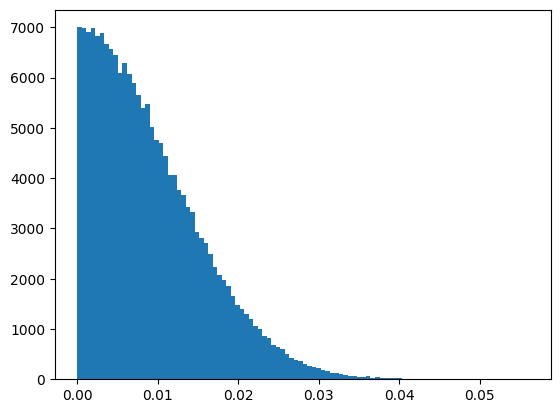

In [59]:
# plot histogram of the weights[1]
plt.hist(w[0].flatten(), bins=100)

(array([7.002e+03, 6.987e+03, 6.916e+03, 6.985e+03, 6.835e+03, 6.890e+03,
        6.665e+03, 6.570e+03, 6.445e+03, 6.087e+03, 6.282e+03, 6.075e+03,
        5.893e+03, 5.659e+03, 5.394e+03, 5.480e+03, 5.025e+03, 4.762e+03,
        4.706e+03, 4.443e+03, 4.059e+03, 4.054e+03, 3.773e+03, 3.672e+03,
        3.433e+03, 3.325e+03, 2.937e+03, 2.810e+03, 2.703e+03, 2.501e+03,
        2.232e+03, 2.074e+03, 1.966e+03, 1.859e+03, 1.660e+03, 1.471e+03,
        1.399e+03, 1.290e+03, 1.197e+03, 1.050e+03, 9.910e+02, 8.560e+02,
        8.130e+02, 6.740e+02, 6.370e+02, 6.040e+02, 4.980e+02, 4.320e+02,
        3.810e+02, 3.550e+02, 3.040e+02, 2.550e+02, 2.410e+02, 2.280e+02,
        1.880e+02, 1.660e+02, 1.330e+02, 1.290e+02, 1.040e+02, 8.900e+01,
        7.200e+01, 6.400e+01, 5.200e+01, 5.200e+01, 6.300e+01, 3.100e+01,
        4.800e+01, 2.100e+01, 2.800e+01, 2.300e+01, 1.700e+01, 1.600e+01,
        1.300e+01, 6.000e+00, 1.100e+01, 7.000e+00, 5.000e+00, 1.000e+00,
        4.000e+00, 5.000e+00, 5.000e+0

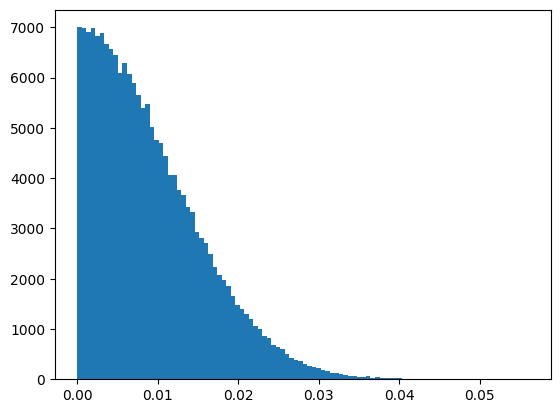

In [60]:
plt.hist(win_original.flatten(), bins=100)